<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/selfDUDL_CodeChallenge_KaimingvxXavier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 1: wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-2-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [33]:
# global parameter
numepochs = 600

def trainTheModel(model):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

# Now to create the fitted model

## Kaiming Model

In [22]:
# create and train a model
kaiming = ANNwine()
kaiming_trainAcc,kaiming_testAcc, kaiming_losses = trainTheModel(kaiming)


## Xavier init weight

In [30]:
# create and train a model
xavier = ANNwine()
for p in xavier.named_parameters() :
  if "weight" in p[0] :
    nn.init.xavier_normal_(p[1].data)
  # print(f"{p[0]}, {p[1].shape}")

In [31]:
xavier_trainAcc,xavier_testAcc, xavier_losses = trainTheModel(xavier)

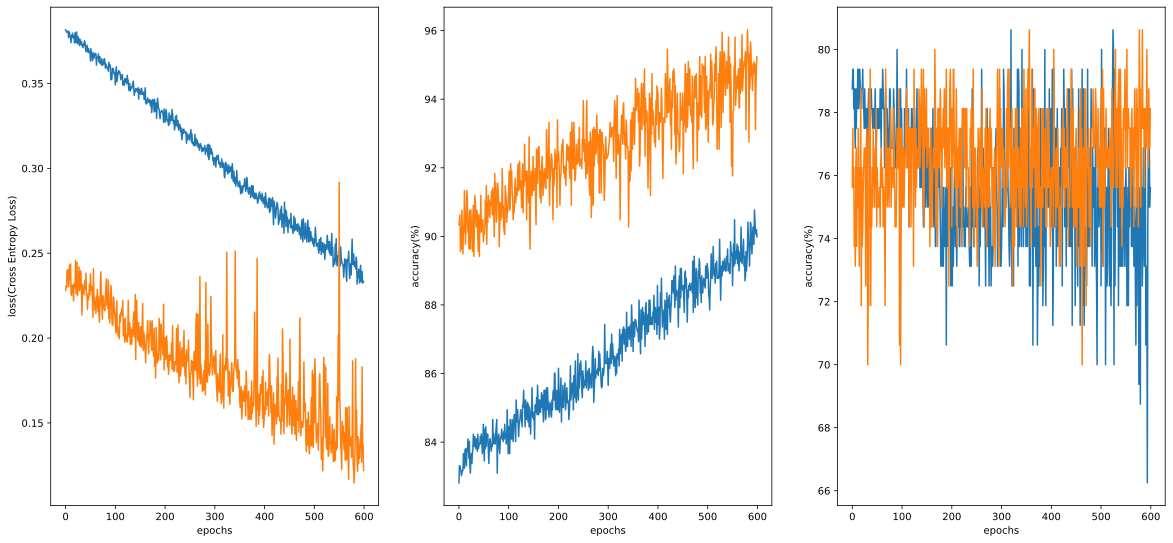

In [32]:
fig, ax = plt.subplots(1,3, figsize =(20,9))
ax[0].plot(kaiming_losses)
ax[0].plot(xavier_losses)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss(Cross Entropy Loss)")

ax[1].plot(kaiming_trainAcc)
ax[1].plot(xavier_trainAcc)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy(%)")

ax[2].plot(kaiming_testAcc)
ax[2].plot(xavier_testAcc)
ax[2].set_xlabel("epochs")
ax[2].set_ylabel("accuracy(%)")
plt.show()

# get 10 statistical data

In [34]:
kaiming_results = []

for i in range(10) :
  kaiming = ANNwine()
  kaiming_trainAcc,kaiming_testAcc, kaiming_losses = trainTheModel(kaiming)
  performance = {
      "id" : i,
      "train_acc" : np.mean(kaiming_trainAcc[-5:]),
      "test_acc" : np.mean(kaiming_testAcc[-5:]),
      "loss" : torch.mean(kaiming_losses[-5:])
  }
  kaiming_results.append(performance)


In [35]:
xavier_results = []

for i in range(10) :
  xavier = ANNwine()
  for p in xavier.named_parameters() :
    if "weight" in p[0] :
      nn.init.xavier_normal_(p[1].data)
  xavier_trainAcc,xavier_testAcc, xavier_losses = trainTheModel(xavier)
  performance = {
      "id" : i,
      "train_acc" : np.mean(xavier_trainAcc[-5:]),
      "test_acc" : np.mean(xavier_testAcc[-5:]),
      "loss" : torch.mean(xavier_losses[-5:])
  }
  xavier_results.append(performance)

In [40]:
kaiming_results[0]["loss"]

tensor(0.6868)

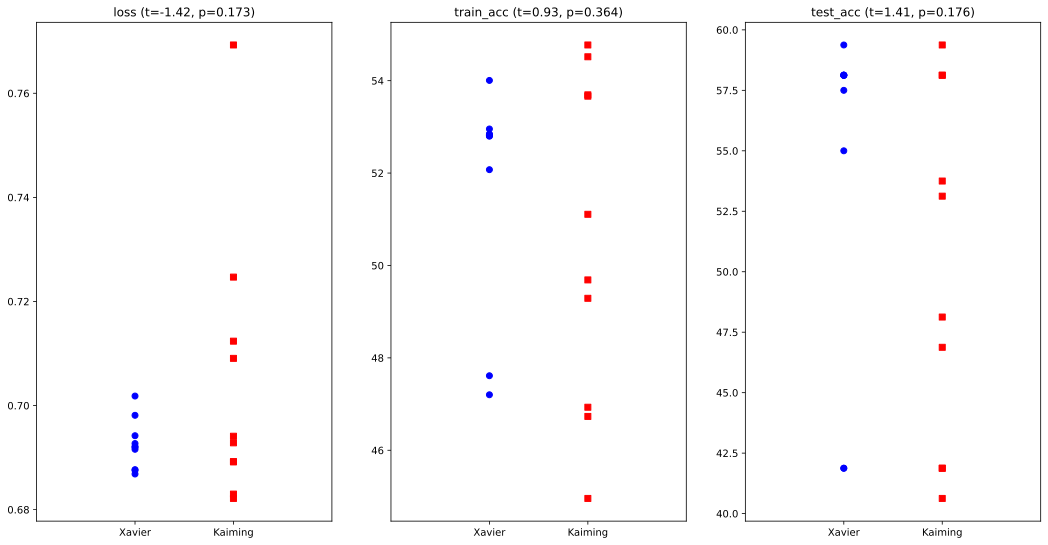

In [46]:
fig, ax = plt.subplots(1,3, figsize = (18,9))
metrics = ['loss', 'train_acc', 'test_acc' ]

for i, metric in enumerate(metrics) :
  ax[i].plot(np.zeros(10), [j[metric] for j in kaiming_results], "bo")
  ax[i].plot(np.ones(10), [j[metric] for j in xavier_results], "rs")

  t,p = stats.ttest_ind([j[metric] for j in kaiming_results],[j[metric] for j in xavier_results])
  title = '%s (t=%.2f, p=%.3f)' %(metrics[i],t,p)


  # make the plot look a bit nicer
  ax[i].set_xlim([-1,2])
  ax[i].set_xticks([0,1])
  ax[i].set_xticklabels(['Xavier','Kaiming'])
  ax[i].set_title(title)


